In [ ]:
# mount image
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
COLAB = True
print("Note: using Google CoLab")
%cd '/content/gdrive/My Drive/projects/colorizing'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Note: using Google CoLab
/content/gdrive/My Drive/projects/colorizing


In [ ]:
# install package to download some images
!git clone https://github.com/ultralytics/flickr_scraper
%cd flickr_scraper
!pip install -U -r requirements.txt

Cloning into 'flickr_scraper'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 91 (delta 53), reused 40 (delta 16), pack-reused 0
Unpacking objects: 100% (91/91), done.
/content/gdrive/My Drive/projects/colorizing/flickr_scraper/flickr_scraper
     |████████████████████████████████| 61kB 5.5MB/s 


In [ ]:
# download images
%cd '/content/gdrive/My Drive/projects/colorizing/flickr_scraper/'
!python3 flickr_scraper.py --search 'family portrait' --n 2000 --download


/content/gdrive/My Drive/projects/colorizing/flickr_scraper
0/2000 https://live.staticflickr.com/8261/8610578193_9785599368_o.jpg
1/2000 https://farm3.staticflickr.com/2620/4199957480_41cd78583b_b.jpg
2/2000 https://live.staticflickr.com/5611/31377366705_6e9e32064f_o.jpg
3/2000 https://farm2.staticflickr.com/1303/1316850464_059ccf6457_b.jpg
4/2000 https://live.staticflickr.com/8449/7978545929_d89a536ef5_o.jpg
5/2000 https://live.staticflickr.com/3233/2979086027_5c9a817e9e_o.jpg
6/2000 https://farm66.staticflickr.com/65535/48868241033_bd0962f1d9_b.jpg
7/2000 https://farm4.staticflickr.com/3281/2955467558_5bfbc9084b_b.jpg
8/2000 https://live.staticflickr.com/3609/3320241710_46e3820745_o.jpg
9/2000 https://live.staticflickr.com/65535/49884701707_26cc850efb_o.jpg
10/2000 https://farm4.staticflickr.com/3253/3051817948_c836d94a45_b.jpg
11/2000 https://farm4.staticflickr.com/3291/3050980663_f0db3a928d_b.jpg
12/2000 https://farm4.staticflickr.com/3019/3051817406_e84914928c_b.jpg
13/2000 https:

In [ ]:
# actual code
#%cd /content/gdrive/My Drive/projects/colorizing/
from keras.layers import Conv2D, UpSampling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np
from PIL import Image
from tqdm import tqdm
import os #
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave, imshow
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

path = '/content/gdrive/My Drive/projects/colorizing/flickr_scraper/images/family_portrait/'


i=0
training_data=[]
X =[]
Y =[]
for filename in tqdm(os.listdir(path)): # przeszkukiwanie plików w folderze
    im_path = os.path.join(path,filename) 
    image =load_img(im_path)
    image = image.resize((256,256), Image.ANTIALIAS)
    lab = rgb2lab(image)
    X.append(lab[:,:,0]) 
    Y.append(lab[:,:,1:])
    
X = np.reshape(X, (-1, 256, 256,1)) #zmiana konfiguracji, 1 wymiar to liczba zdjec
X = X.astype(np.float32) #zmiana typu na float
Y = np.reshape(Y, (-1, 256, 256,2)) #zmiana konfiguracji, 1 wymiar to liczba zdjec
Y = Y.astype(np.float32) #zmiana typu na float
Y = Y / 128 # normalizacja wokół zera (-1,1)


100%|██████████| 1639/1639 [31:47<00:00,  1.16s/it]


In [ ]:
Y.shape

(1639, 256, 256, 2)

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))

#Decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 512)       1180160   
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 512)      

In [ ]:

model.fit(X,Y,validation_split=0.1, epochs=300, batch_size=16)
model.save('/content/gdrive/My Drive/projects/colorizing/colorize_portrait.model')

Train on 1475 samples, validate on 164 samples
Epoch 1/300
1475/1475 [==============================] - 29s 20ms/step - loss: 0.0224 - accuracy: 0.6255 - val_loss: 0.0128 - val_accuracy: 0.6101
Epoch 2/300
1475/1475 [==============================] - 16s 11ms/step - loss: 0.0143 - accuracy: 0.6325 - val_loss: 0.0127 - val_accuracy: 0.6128
Epoch 3/300
1475/1475 [==============================] - 16s 11ms/step - loss: 0.0141 - accuracy: 0.6411 - val_loss: 0.0128 - val_accuracy: 0.5754
Epoch 4/300
1475/1475 [==============================] - 16s 11ms/step - loss: 0.0140 - accuracy: 0.6397 - val_loss: 0.0126 - val_accuracy: 0.6069
Epoch 5/300
1475/1475 [==============================] - 16s 11ms/step - loss: 0.0140 - accuracy: 0.6429 - val_loss: 0.0124 - val_accuracy: 0.6043
Epoch 6/300
1475/1475 [==============================] - 16s 11ms/step - loss: 0.0141 - accuracy: 0.6294 - val_loss: 0.0124 - val_accuracy: 0.6058
Epoch 7/300
1475/1475 [==============================] - 16s 11ms/step 

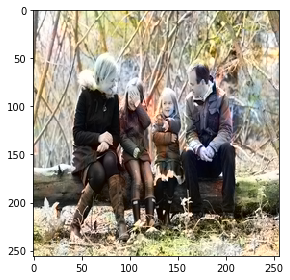

In [ ]:
image_test =load_img('/content/gdrive/My Drive/projects/colorizing/flickr_scraper/images/5.jpg')
image_test = image_test.resize((256,256), Image.ANTIALIAS)
lab_test = rgb2lab(image_test)
X_test = lab_test[:,:,0]
X_test = np.reshape(X_test, (-1, 256, 256,1)) #zmiana konfiguracji, 1 wymiar to liczba zdjec
X_test = X_test.astype(np.float32) #zmiana typu na float
X_test = X_test # normalizacja wokół zera (-1,1)

output1 = model.predict(X_test)
output1 = output1 * 128 
X_test 

result = np.zeros((256, 256, 3))
result[:,:,0] = X_test[0,:,:,0]
result[:,:,1:] = output1[0]
imshow(lab2rgb(result))





In [ ]:
output1.shape

(1, 256, 256, 2)